In [ ]:
import time
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# 0. Using ChatGPT to help you understand optimizers

Recently I had an interview question for Deep Learning candidates, and they were not able to answer these questions.

Write one paragraph with the help of ChatGPT (or equivalent) explaining each one of the following optimizers, and in the last paragraph, reviewed by the notes from the lab last week, write a comparison of the advantages and disadvantages of each one.  Please note that ChatGPT may hallucinate, so you need to double-check what ChatGPT answers.

- Stochastic Gradient Descent
  
  Stochastic Gradient Descent (SGD) is an optimization algorithm used to find the minimum of a given function, typically used within machine learning and deep learning. In SGD, you use one data sample at a time to calculate the gradient of the loss function with respect to the parameters within a model. Then, you update each parameter in the opposite direction of the gradient, until the model has reached the minimum point of the loss function.
- SGD with momentum

  SGD with momentum is an addon to Stochastic Gradient Descent. Unlike regular SGD, SGD with momentum doesn't update the parameters with the current gradient right away. Instead, it stores a moving average of the previous gradients which the it calls its velocity, and uses both the velocity and the current gradient to update the parameters of the model.
- RMSProp

  RMSProp is another optimizer algorithm that is an addon to Stochastic Gradient Descent. Like momentum, RMSProp maintains a moving average, but unlike momentum, it keeps a moving average of the squared gradient. RMSProp then uses this moving average to adjust the base learning rate of SGD, instead of adding to the parameter directly like with momentum.
- Adadelta

  Adadelta is an addon to RMSProp. Like RMSProp, it keeps a moving average of squared gradient descents, but unlike RMSProp, it also keeps a moving average of squared parameter updates. This moving average of squared parameter updates is then used to calculate the learning rate for gradient descent, meaning that for Adadelta, there is no fixed learning rate.

- Adam

  Adam, short for Adaptive Moment Estimation, is a combination of both the momentum and RMSProp optimizers. What this means is that Adam includes both a velocity term to add to the gradient descent as well as an adaptive learning rate that depends on the moving average of squared gradients. Both equations for velocity and average of squared gradients are updated every sample, before also going some bias correction to counter some initial bias.
- Adam with warmup

  Adam with warmup is a variation on the standard Adam optimizer. With warmup, the Adam optimizer doesn't start with the full base learning rate, but starts out small and gradually increases over a predefined number of steps until it reaches its full base learning rate. After this point, it acts like the regular Adam optimizer.

- Advantages and Disadvantages to each optimizer

  SGD is the standard gradient descent model, used for both its simplicity and low amount of required memory for it to run. However, it has two main issues, one being that it is susceptible to low gradient areas where it can't make progress (such as saddle points, local minimas, and ravines), and that it is heavily dependent on the chosen learning rate for how well the model performs. Each of the optimizers listed after SGD attempts to solve these two main issues.
  
  With Momentum, it aims to speed up the training through low gradient areas with its velocity term, though it does lead to issues of overshooting the global minima at times. With RMSProp, it tries to create an adaptive learning rate based on previous gradients, but can still struggle with low gradient areas. Adadelta is another optimizer that gets rid of the base learning rate entirely, and instead depends on averages for gradients and parameter updates to choose its learning rate. However, this can sometimes lead to slower converging toward the optimal values. Finally, we have Adam, which is one of the most popular optimizers used in training. It combines the features of both Momentum and RMSProp, which leads Adam to do well both in low gradient areas as well as have an adaptive learning rate to deal with noisy samples and unexpectedly high gradient areas. Adam does sometimes have a hard time with large gradients, especially at the beginning of the training, which where a warmup comes into play. By gradually increasing the learning rate up to the desired base rate over the first iterations of training, we can more smoothly train our model using the Adam optimizer without worrying about large jumps in parameter updates.

# 1. Optimizers

In this lab, we will implement some optimizers and see how they behave.

## 1.1. Solving $A x = b$

In [ ]:
A = np.array([[2,1,3],[2,6,8],[6,8,18]]).astype(np.float32)
b = np.array([[1],[3],[5]]).astype(np.float32)

In [ ]:
print(np.dot(np.linalg.inv(A), b).shape)

(3, 1)


In [ ]:
# this is the optimization function.
# we want to obtain x so that (Ax - b)**2 is minimized.

def F(x):
  # (3,3) x (3,1) - (3,1) -> (3, 1)
  return np.dot(A,x) - b

# definition of loss function (MSE of F(x))

def L(x):
  # (1,3) x (3,1) -> (1,1)
  return np.dot(F(x).T, F(x))

# definition of gradient d(MSE(F(x))/dx
def g(x):
  return 2 * np.dot(A.T, F(x))

In [ ]:
# plot loss over time until it converges

def GD(x, alpha, N=1000, step=100, verbose=False):
  """Implementation of gradient descent loop."""
  i = 0
  history = []

  while i < N:
    x = x - alpha * g(x)
    loss = np.max(np.abs(L(x)))
    history.append(loss)
    if verbose and i % step == 0:
      print(i, np.round(loss,4), np.round(x.flatten(), 2))
    i += 1
    if loss < 1e-4:
      break

  return x, history

def Momentum(x, alpha, beta, verbose=False):
  history = []
  N = 1000
  vt = 0

  for i in range(N):
    vt = beta * vt + alpha * g(x)
    x = x - vt
    loss = np.max(np.abs(L(x)))
    history.append(loss)

    if verbose and i % 100 == 0:
      print(i, np.round(loss,4), np.round(x.flatten(), 2))
    if loss < 1e-4:
      break

  return x, history

def Adadelta(x, beta, verbose=False):
  history = []
  N = 1000
  avg_grad2 = 0
  avg_delta2 = 0
  epsilon = 1e-7

  for i in range(N):
    avg_grad2 = beta * avg_grad2 + (1 - beta) * g(x) * g(x)
    delta = - np.sqrt(avg_delta2 + epsilon) / np.sqrt(avg_grad2 + epsilon) * g(x)
    x = x + delta
    avg_delta2 = beta * avg_delta2 + (1 - beta) * delta * delta
    loss = np.max(np.abs(L(x)))
    history.append(loss)

    if verbose and i % 100 == 0:
      print(i, np.round(loss,4), np.round(x.flatten(), 2))
    if loss < 1e-4:
      break

  return x, history

def Adam(x, alpha, beta1, beta2, verbose=False):
  history = []
  N = 1000
  mt = 0
  vt = 0
  epsilon = 1e-7

  for i in range(N):
    mt = beta1 * mt + (1 - beta1) * g(x)
    vt = beta2 * vt + (1 - beta2) * g(x) * g(x)
    mt_hat = mt / (1 - pow(beta1, i+1))
    vt_hat = vt / (1 - pow(beta2, i+1))
    x = x - alpha * mt_hat / (np.sqrt(vt_hat) + epsilon)
    loss = np.max(np.abs(L(x)))
    history.append(loss)

    if verbose and i % 100 == 0:
      print(i, np.round(loss,4), np.round(x.flatten(), 2))
    if loss < 1e-4:
      break

  return x, history

# ramp up alpha in the first epochs 0 -> alpha for first ramp_n epochs
def AdamWithWarmup(x, ramp_n, alpha, beta1, beta2, verbose=False):
  history = []
  N = 1000
  mt = 0
  vt = 0
  epsilon = 1e-7

  for i in range(N):
    mt = beta1 * mt + (1 - beta1) * g(x)
    vt = beta2 * vt + (1 - beta2) * g(x) * g(x)

    if i < ramp_n:
      alpha_t = alpha * (i+1) / ramp_n
    else:
      alpha_t = alpha

    mt_hat = mt / (1 - pow(beta1, i+1))
    vt_hat = vt / (1 - pow(beta2, i+1))
    x = x - alpha_t * mt_hat / (np.sqrt(vt_hat) + epsilon)
    loss = np.max(np.abs(L(x)))
    history.append(loss)

    if verbose and i % 100 == 0:
      print(i, np.round(loss,4), np.round(x.flatten(), 2))
    if loss < 1e-4:
      break

  return x, history

In [ ]:
x1 = np.random.uniform(-0.1,0.1,size=(3,1))
x2 = np.copy(x1)
x3 = np.copy(x1)
x4 = np.copy(x1)
x5 = np.copy(x1)

In [ ]:
x1, history_gd = GD(x1, alpha=0.0001, verbose=True)

0 38.5848 [-0.03  0.02 -0.01]
100 0.1925 [0.04 0.14 0.21]
200 0.1694 [0.04 0.16 0.2 ]
300 0.1505 [0.04 0.17 0.2 ]
400 0.1351 [0.03 0.18 0.19]
500 0.1223 [0.03 0.19 0.19]
600 0.1118 [0.03 0.2  0.19]
700 0.1031 [0.03 0.21 0.18]
800 0.0958 [0.03 0.22 0.18]
900 0.0897 [0.03 0.22 0.18]


In [ ]:
x2, history_mo = Momentum(x2, alpha=0.0001, beta = 0.3, verbose=True)

0 38.5848 [-0.03  0.02 -0.01]
100 0.182 [0.04 0.15 0.21]
200 0.153 [0.04 0.17 0.2 ]
300 0.1311 [0.03 0.18 0.19]
400 0.1146 [0.03 0.2  0.19]
500 0.102 [0.03 0.21 0.18]
600 0.0922 [0.03 0.22 0.18]
700 0.0845 [0.03 0.23 0.17]
800 0.0784 [0.03 0.24 0.17]
900 0.0734 [0.03 0.25 0.16]


In [ ]:
x3, history_add = Adadelta(x3, beta=0.3, verbose=True)

0 48.1601 [-0.04  0.   -0.04]
100 1.4079 [0.12 0.16 0.12]
200 0.033 [0.11 0.3  0.11]
300 0.0149 [0.17 0.34 0.07]
400 0.015 [0.18 0.35 0.06]
500 0.0155 [0.18 0.35 0.06]
600 0.0164 [0.19 0.35 0.05]
700 0.0175 [0.2  0.35 0.05]
800 0.0189 [0.21 0.36 0.05]
900 0.0205 [0.21 0.36 0.04]


In [ ]:
x4, history_ada = Adam(x4, alpha=0.002, beta1=0.3, beta2=0.3, verbose=True)

0 47.348 [-0.03  0.   -0.04]
100 0.1253 [0.15 0.2  0.15]
200 0.0206 [0.14 0.33 0.09]
300 0.0064 [0.21 0.36 0.05]
400 0.0024 [0.26 0.38 0.03]
500 0.0011 [0.28 0.39 0.01]
600 0.0002 [0.29 0.39 0.01]


In [ ]:
x5, history_adawu = AdamWithWarmup(x5, ramp_n=100, alpha=0.002, beta1=0.3, beta2=0.3, verbose=True)

0 48.3402 [-0.04  0.   -0.04]
100 10.4266 [0.07 0.1  0.06]
200 0.0352 [0.11 0.3  0.11]
300 0.0077 [0.2  0.36 0.05]
400 0.0025 [0.25 0.38 0.03]
500 0.0007 [0.27 0.39 0.02]
600 0.0002 [0.29 0.39 0.01]


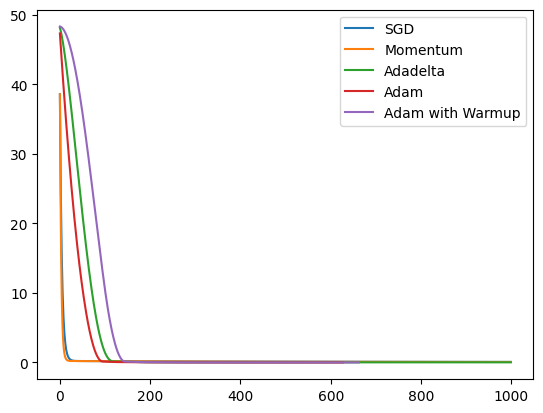

In [ ]:
plt.plot(history_gd, label='SGD')
plt.plot(history_mo, label='Momentum')
plt.plot(history_add, label='Adadelta')
plt.plot(history_ada, label='Adam')
plt.plot(history_adawu, label='Adam with Warmup')
plt.legend()
plt.show()

In [ ]:
# For Ax = b, the solution is (A**-1 * b).T
print("Solution is: ", np.dot(np.linalg.inv(A),b).T)

Solution is:  [[0.30000007 0.39999986 0.        ]]


## 1.2. Function ${(1-x_0)}^2 + 100 {(x_1 - x_0^2)}^2$

### [ Rosenbrock function ]

In [ ]:
def F(x):
  return np.power(1-x[0],2) + 100.0*np.power(x[1] - np.power(x[0],2),2)

# definition of loss function (F(x)) - let's see when this function is 0
def L(x):
  return F(x)

# definition of gradient
def g(x):
  return np.array([
    -(1-x[0]) - 100.0*4*x[0]*(x[1] - np.power(x[0],2)),
    100.0*2*(x[1] - np.power(x[0],2))
  ])

In [ ]:
x1 = np.random.uniform(-0.01,0.01,size=(2,1))
x2 = np.copy(x1)
x3 = np.copy(x1)
x4 = np.copy(x1)
x5 = np.copy(x1)
alpha = 0.001
beta1 = 0.3
beta2 = 0.3
ramp_n = 100

In [ ]:
x1, history_gd = GD(x1, alpha, verbose=True)

0 0.9906 [0.01 0.  ]
100 0.8117 [0.1  0.01]
200 0.6743 [0.18 0.03]
300 0.5693 [0.25 0.06]
400 0.4882 [0.3  0.09]
500 0.4242 [0.35 0.12]
600 0.3728 [0.39 0.15]
700 0.3306 [0.43 0.18]
800 0.2955 [0.46 0.21]
900 0.2658 [0.48 0.23]


In [ ]:
x2, history_mo = Momentum(x2, alpha, beta1, verbose=True)

0 0.9906 [0.01 0.  ]
100 0.7484 [0.13 0.02]
200 0.5826 [0.24 0.05]
300 0.4682 [0.32 0.1 ]
400 0.3862 [0.38 0.14]
500 0.325 [0.43 0.18]
600 0.2777 [0.47 0.22]
700 0.2402 [0.51 0.26]
800 0.2098 [0.54 0.29]
900 0.1847 [0.57 0.32]


In [ ]:
x3, history_add = Adadelta(x3, alpha, verbose=True)

0 0.9925 [0. 0.]
100 0.6086 [0.22 0.05]
200 0.3148 [0.44 0.19]
300 0.2472 [0.5  0.25]
400 0.236 [0.52 0.26]
500 0.2364 [0.52 0.26]
600 0.237 [0.52 0.26]
700 0.2376 [0.52 0.26]
800 0.2382 [0.52 0.26]
900 0.2388 [0.52 0.26]


In [ ]:
x4, history_ada = Adam(x4, alpha, beta1, beta2, verbose=True)

0 0.9906 [0.01 0.  ]
100 0.8001 [0.11 0.01]
200 0.6312 [0.21 0.04]
300 0.4824 [0.31 0.09]
400 0.3535 [0.41 0.16]
500 0.2448 [0.51 0.26]
600 0.1635 [0.6  0.35]
700 0.1068 [0.67 0.45]
800 0.0686 [0.74 0.54]
900 0.0435 [0.79 0.63]


In [ ]:
x5, history_adawu = AdamWithWarmup(x5, ramp_n, alpha, beta1, beta2, verbose=True)

0 0.9934 [0.   0.01]
100 0.8911 [0.06 0.  ]
200 0.7123 [0.16 0.02]
300 0.5535 [0.26 0.07]
400 0.4148 [0.36 0.13]
500 0.2961 [0.46 0.21]
600 0.199 [0.55 0.31]
700 0.132 [0.64 0.4 ]
800 0.0845 [0.71 0.5 ]
900 0.0527 [0.77 0.59]


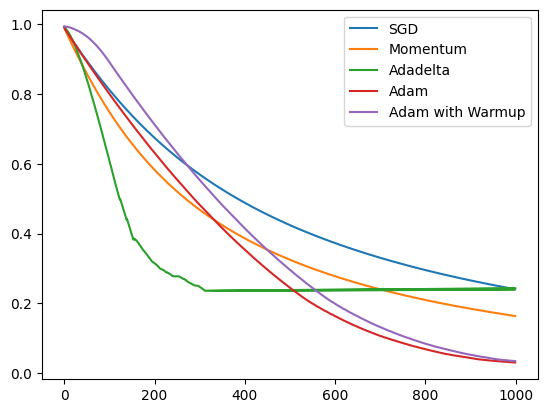

In [ ]:
plt.plot(history_gd, label='SGD')
plt.plot(history_mo, label='Momentum')
plt.plot(history_add, label='Adadelta')
plt.plot(history_ada, label='Adam')
plt.plot(history_adawu, label='Adam with Warmup')
plt.legend()
plt.show()

## 1.3. Deep Learning Package From Lab2

Using the package you created in lab2, define a network and train the loss functions specified before. Plot accuracy of models.

In [ ]:
import numpy as np

from keras.datasets import mnist
from keras.utils import to_categorical

def load_MNIST_data():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  print(x_train.shape)

  x_train = x_train.reshape(x_train.shape[0], 784).astype(np.float32) / 255.0
  x_test = x_test.reshape(x_test.shape[0], 784).astype(np.float32) / 255.0

  print(x_train.shape)

  y_train = to_categorical(y_train, 10).astype(np.float32)
  y_test = to_categorical(y_test, 10).astype(np.float32)

  print(x_train.shape, y_train.shape)

  return x_train, y_train, x_test, y_test

In [ ]:
def relu(x):
  """Computes relu of function."""
  return x * (x >= 0)


def sigmoid(x):
  """Computes sigmoid of function."""
  return 1 / (1 + np.exp(-x))

def linear(x):
  """Return linear function of itself."""
  return x

def softmax(x):
  """Computes softmax of function."""
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def d_linear(x):
    return np.ones_like(x)

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def d_relu(x):
    return (x >= 0).astype(np.float32)

def d_softmax(x):
    return softmax(x) * (1 - softmax(x))

activations = {
    "linear": linear,
    "relu": relu,
    "sigmoid": sigmoid,
    "softmax": softmax
}

d_activations = {
    "linear": d_linear,
    "relu": d_relu,
    "sigmoid": d_sigmoid,
    "softmax": d_softmax
}

def standardize(x):
    # standardize = x - mean(x) / std(x)
    return (x - np.mean(x, axis = 0))/np.std(x, axis = 0, keepdims=True)

def mse(y, p):
  """Computes Mean-Square Error between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       MSE of y-p
  """
  #assert p.shape == y.shape
  return np.mean((y - p)**2)

def binary_crossentropy(y, p):
  """Computes binary crossentropy between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       BCE of (y, p) = mean(sum(y log(p) + (1-y) log(1-p)))
  """
  return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def cross_entropy_loss(y_true, y_pred):
    """
    Compute cross entropy loss.

    Args:
        y_true: one-hot encoded true labels (B, num_classes)
        y_pred: predicted probabilities (B, num_classes)
    """
    epsilon = 1e-10  # Small constant to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions for numerical stability
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

def cross_entropy_gradient(y_true, y_pred):
    """
    Compute gradient of cross entropy loss.

    Args:
        y_true: one-hot encoded true labels (B, num_classes)
        y_pred: predicted probabilities (B, num_classes)
    """
    return (y_pred - y_true) / y_pred.shape[0]

def initialize_weights(shapes, outputs):
    """Initializes weights of model according to shape.
     Args:
       shapes = [784, 300, 10]
       outputs = ["linear", "sigmoid"]

     returns:
       model with uniform random weights [-1,+1], zero bias and output function
       [
        [random(784, 300), zeros(300), "linear"]
        [random(300, 10), zeros(10), "sigmoid"]
       ]

    """
    # do your code here
    model = []
    for i in range(len(shapes)-1):
      layer = [np.random.uniform(-1, 1, (shapes[i], shapes[i+1])), np.zeros(shapes[i+1]), outputs[i]]
      model.append(layer)
    return model

def forward(x, model):
    """Performs forward pass of training step.

     Args:
       x: input tensor of shape (B, N0)
       model: list of model weights (see initialize weights)
     Returns:
       List containing dictionary { "y": y, "z": z } for each layer of network.
       [{"y": y1, "z": z1}, {"y": y2, "z": z2}]
    """
    result = []
    y = x
    for layer in model:
      # layer = [ w[i], b[i], 'relu']
      z = np.dot(y, layer[0]) + layer[1]  # (B,N1) + (N1,N2)
      y = activations[layer[2]](z)
      result.append({'y': y, 'z': z})

    return result

def predict(x, model):
  """Predicts the output of a model.

     Args:
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
     Returns:
       Prediction of model, with the same shape as the labeled data (B, No).
  """
  fwd = forward(x, model)
  return fwd[-1]["y"]

def backward(y, x, model, loss):
  """Computes backward step of training.
     Args:
       y: labeled data of size (B, No)
       x: input tensor of shape (B, Ni)
       model: list of model weights (see initialize weights)
       loss: one of ("mse", "binary_crossentropy")
     Returns:
       tuple with loss evaluation of (y, predict(x)) and list of dictionary
       containing { "dw": dw, "db": db } for each layer of network. Remember
       that shape of dw for each layer should be equal to shape of weight for
       the same layer.
       [{"dw": dw1, "db": db1}, {"dw": dw2, "db": db2}]
  """
  # add backward here
  p = predict(x, model)
  p = softmax(p)
  fwd = forward(x, model)

  if loss == "mse":
    loss_evaluation = mse(y, p)

    N = y.shape[0]
    deriv_loss = -2/N * (y - p)

  elif loss == "binary_crossentropy":
    loss_evaluation = binary_crossentropy(y, p)

    deriv_loss = -(y/p - (1-y)/(1-p))

  elif loss == "cross_entropy":
    loss_evaluation = cross_entropy_loss(y, p)

    deriv_loss = cross_entropy_gradient(y, p)

  #print("back")
  deriv_y = deriv_loss
  dweights = []
  for i in range(len(model) - 1, -1, -1):
    layer = model[i]

    if i == 0:
      output_prev = x
    else:
      output_prev = fwd[i-1]["y"]

    # gradient of activation function

    # z = W * y + b
    # dl/dy is just the derivation of the loss function
    # dy/dz = derivation of the activation function
    # deriv_z = dl / dz = dl/dy * dy/dz
    z = fwd[i]['z']
    deriv_activation = d_activations[layer[2]](z)
    deriv_z = deriv_y * deriv_activation


    # gradients of the weights and biases

    # dl / dw = output_prev transposed x dl/dz
    dw = np.dot(output_prev.T, deriv_z)

    # dl/db = sum(dl/dz)
    db = np.sum(deriv_z, axis=0, keepdims=True)


    # repeat backpropagation with new dy
    deriv_y = np.dot(deriv_z, layer[0].T)

    dweights.append({"dw":dw, "db":db})

  dweights.reverse()

  return loss_evaluation, dweights

def GD_update(weights, dweights, alpha):
  """Gradient descent for weights and biases."""
  for i in range(len(weights)):
    weights[i][0] += - alpha * dweights[i]["dw"]
    weights[i][1] += - alpha * dweights[i]["db"].reshape(weights[i][1].shape)

def accuracy(y, p):
  """Computes accuracy between y and p.
     Args:
       y: labeled data of size (B, No)
       p: predicted label of size (B, No)
     Returns:
       accuracy of (y, p)
  """
  return np.mean(np.argmax(y, axis=1) == np.argmax(p, axis=1))

In [ ]:

def train_mnist_with_optimizer(optimizer='GD', n_epochs=30, batch_size=128, learning_rate = 0.001):
  x_train, y_train, x_test, y_test = load_MNIST_data()
  #print(x_train)
  #x_train = standardize(x_train)
  #x_test = standardize(x_test)

  layers = [784, 300, 100, 10]
  outputs = ["relu", "relu", "linear"]
  model = initialize_weights(layers, outputs)

  batches = x_train.shape[0] // batch_size

  if optimizer == 'GD':
    alpha = learning_rate
  elif optimizer == 'Momentum':
    alpha = learning_rate
    beta = 0.3
    velocity = [{"w": np.zeros_like(layer[0]), "b": np.zeros_like(layer[1])} for layer in model]
  elif optimizer == 'Adadelta':
    beta = 0.3
    avg_grad2 = [{"w": np.zeros_like(layer[0]), "b": np.zeros_like(layer[1])} for layer in model]
    avg_delta2 = [{"w": np.zeros_like(layer[0]), "b": np.zeros_like(layer[1])} for layer in model]
    epsilon = 1e-7
  elif optimizer == 'Adam' or optimizer == 'AdamWithWarmup':
    alpha = learning_rate
    beta1 = 0.3
    beta2 = 0.3
    mt = [{"w": np.zeros_like(layer[0]), "b": np.zeros_like(layer[1])} for layer in model]
    vt = [{"w": np.zeros_like(layer[0]), "b": np.zeros_like(layer[1])} for layer in model]
    epsilon = 1e-7
    if optimizer == 'AdamWithWarmup':
      ramp_n = 1000

  train_loss = []
  test_loss = []
  train_acc = []
  test_acc = []

  for epoch in range(n_epochs):
    loss_per_epoch = 0
    acc_per_epoch = 0

    indexes = np.random.permutation(x_train.shape[0])
    x_train = x_train[indexes]
    y_train = y_train[indexes]

    for batch in range(batches):
      x = x_train[batch*batch_size:(batch+1)*batch_size]
      y = y_train[batch*batch_size:(batch+1)*batch_size]
      loss, dweights = backward(y, x, model, "mse")
      #print("Batch:" + str(batch) + " Loss:" + str(loss))
      if optimizer == 'GD':
        GD_update(model, dweights, alpha)

      elif optimizer == 'Momentum':
        for i in range(len(model)):
          velocity[i]["w"] = beta * velocity[i]["w"] + alpha * dweights[i]["dw"]
          velocity[i]["b"] = beta * velocity[i]["b"] + dweights[i]["db"]
          model[i][0] -= velocity[i]["w"]
          model[i][1] -= velocity[i]["b"].reshape(model[i][1].shape)

      elif optimizer == 'Adadelta':
        for i in range(len(model)):
          avg_grad2[i]["w"] = beta * avg_grad2[i]["w"] + (1 - beta) * dweights[i]["dw"]**2
          avg_grad2[i]["b"] = beta * avg_grad2[i]["b"] + (1 - beta) * dweights[i]["db"]**2

          dw = -np.sqrt(avg_delta2[i]["w"] + epsilon) / np.sqrt(avg_grad2[i]["w"] + epsilon) * dweights[i]["dw"]
          db = -np.sqrt(avg_delta2[i]["b"] + epsilon) / np.sqrt(avg_grad2[i]["b"] + epsilon) * dweights[i]["db"]

          avg_delta2[i]["w"] = beta * avg_delta2[i]["w"] + (1 - beta) * dw**2
          avg_delta2[i]["b"] = beta * avg_delta2[i]["b"] + (1 - beta) * db**2

          model[i][0] += dw
          model[i][1] += db.reshape(model[i][1].shape)

      elif optimizer == 'Adam' or optimizer == "AdamWithWarmup":
        cur_t = epoch * batches + batch + 1
        if optimizer == 'Adam':
          alpha_t = alpha
        elif optimizer == 'AdamWithWarmup':
          if cur_t <= ramp_n:
            alpha_t = alpha * cur_t / ramp_n
          else:
            alpha_t = alpha

        for i in range(len(model)):
          dw = dweights[i]["dw"]
          db = dweights[i]["db"].reshape(-1)

          mt[i]["w"] = beta1 * mt[i]["w"] + (1 - beta1) * dw
          mt[i]["b"] = beta1 * mt[i]["b"] + (1 - beta1) * db

          vt[i]["w"] = beta2 * vt[i]["w"] + (1 - beta2) * dw**2
          vt[i]["b"] = beta2 * vt[i]["b"] + (1 - beta2) * db**2

          mt_hat_w = mt[i]["w"] / (1 - beta1**cur_t)
          vt_hat_w = vt[i]["w"] / (1 - beta2**cur_t)

          mt_hat_b = mt[i]["b"] / (1 - beta1**cur_t)
          vt_hat_b = vt[i]["b"] / (1 - beta2**cur_t)

          model[i][0] -= alpha_t * mt_hat_w / (np.sqrt(vt_hat_w) + epsilon)
          model[i][1] -= alpha_t * mt_hat_b / (np.sqrt(vt_hat_b) + epsilon)

      loss_per_epoch += loss
      acc_per_epoch += accuracy(y, softmax(predict(x, model)))

    train_loss.append(loss_per_epoch / batches)
    train_acc.append(acc_per_epoch / batches)

    test_loss.append(mse(y_test, softmax(predict(x_test, model))))
    test_acc.append(accuracy(y_test, softmax(predict(x_test, model))))

    if (epoch + 1) % 5 == 0:
      print(f"Epoch {epoch + 1}/{n_epochs}:")
      print(f"  Train Loss: {train_loss[-1]:.4f} | Train Acc: {train_acc[-1]:.4f}")
      print(f"  Test Loss: {test_loss[-1]:.4f} | Test Acc: {test_acc[-1]:.4f}")

  return model, {"train_loss": train_loss, "test_loss": test_loss, "train_acc": train_acc, "test_acc": test_acc}


Training with GD optimizer...
(60000, 28, 28)
(60000, 784)
(60000, 784) (60000, 10)
Epoch 5/30:
  Train Loss: 0.0277 | Train Acc: 0.8630
  Test Loss: 0.0265 | Test Acc: 0.8611
Epoch 10/30:
  Train Loss: 0.0228 | Train Acc: 0.8856
  Test Loss: 0.0233 | Test Acc: 0.8751
Epoch 15/30:
  Train Loss: 0.0204 | Train Acc: 0.8946
  Test Loss: 0.0214 | Test Acc: 0.8827
Epoch 20/30:
  Train Loss: 0.0193 | Train Acc: 0.9001
  Test Loss: 0.0202 | Test Acc: 0.8874
Epoch 25/30:
  Train Loss: 0.0183 | Train Acc: 0.9034
  Test Loss: 0.0195 | Test Acc: 0.8895
Epoch 30/30:
  Train Loss: 0.0174 | Train Acc: 0.9072
  Test Loss: 0.0185 | Test Acc: 0.8917


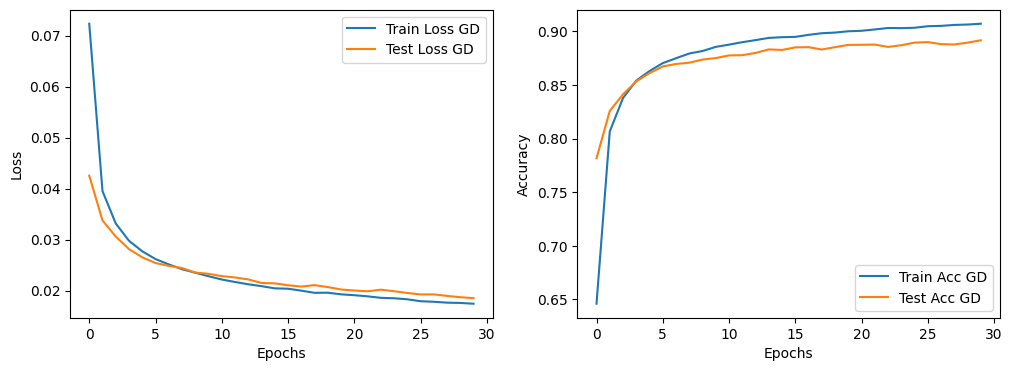

Training with Momentum optimizer...
(60000, 28, 28)
(60000, 784)
(60000, 784) (60000, 10)
Epoch 5/30:
  Train Loss: 0.0353 | Train Acc: 0.7833
  Test Loss: 0.0336 | Test Acc: 0.7731
Epoch 10/30:
  Train Loss: 0.0280 | Train Acc: 0.8199
  Test Loss: 0.0272 | Test Acc: 0.8149
Epoch 15/30:
  Train Loss: 0.0248 | Train Acc: 0.8415
  Test Loss: 0.0242 | Test Acc: 0.8345
Epoch 20/30:
  Train Loss: 0.0228 | Train Acc: 0.8562
  Test Loss: 0.0239 | Test Acc: 0.8365
Epoch 25/30:
  Train Loss: 0.0216 | Train Acc: 0.8648
  Test Loss: 0.0213 | Test Acc: 0.8550
Epoch 30/30:
  Train Loss: 0.0205 | Train Acc: 0.8715
  Test Loss: 0.0197 | Test Acc: 0.8682


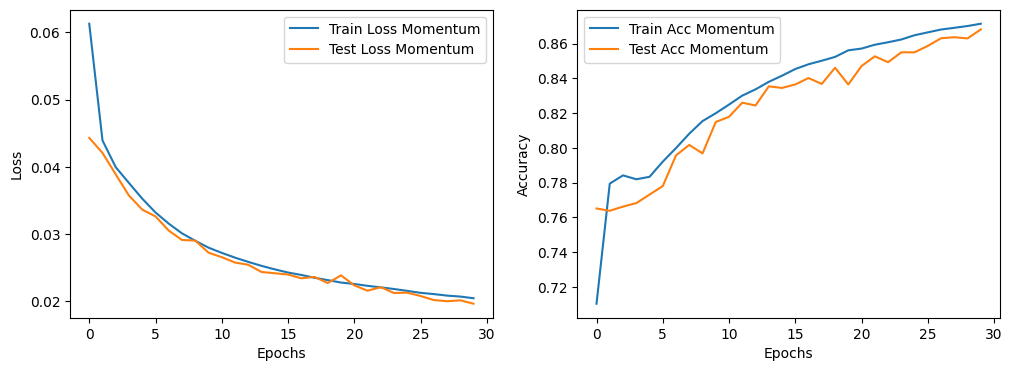

Training with Adadelta optimizer...
(60000, 28, 28)
(60000, 784)
(60000, 784) (60000, 10)
Epoch 5/30:
  Train Loss: 0.0134 | Train Acc: 0.9505
  Test Loss: 0.0150 | Test Acc: 0.9226
Epoch 10/30:
  Train Loss: 0.0080 | Train Acc: 0.9759
  Test Loss: 0.0126 | Test Acc: 0.9344
Epoch 15/30:
  Train Loss: 0.0053 | Train Acc: 0.9868
  Test Loss: 0.0114 | Test Acc: 0.9405
Epoch 20/30:
  Train Loss: 0.0036 | Train Acc: 0.9926
  Test Loss: 0.0109 | Test Acc: 0.9433
Epoch 25/30:
  Train Loss: 0.0024 | Train Acc: 0.9958
  Test Loss: 0.0106 | Test Acc: 0.9451
Epoch 30/30:
  Train Loss: 0.0015 | Train Acc: 0.9976
  Test Loss: 0.0107 | Test Acc: 0.9446


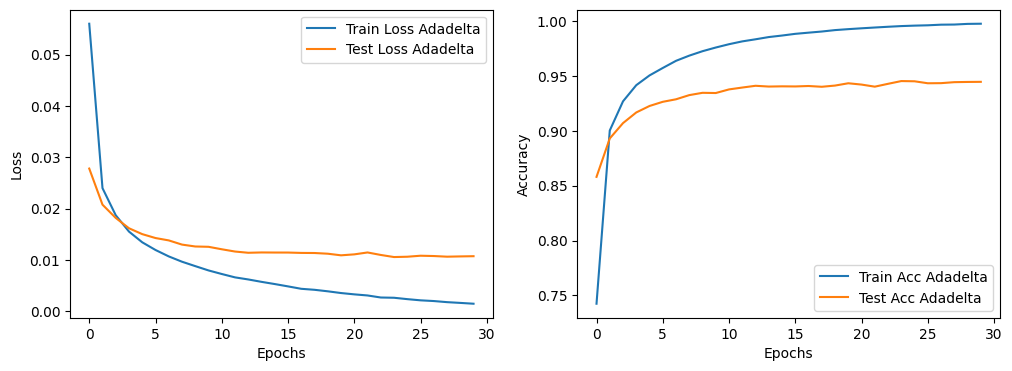

Training with Adam optimizer...
(60000, 28, 28)
(60000, 784)
(60000, 784) (60000, 10)
Epoch 5/30:
  Train Loss: 0.0093 | Train Acc: 0.9722
  Test Loss: 0.0134 | Test Acc: 0.9278
Epoch 10/30:
  Train Loss: 0.0039 | Train Acc: 0.9924
  Test Loss: 0.0108 | Test Acc: 0.9417
Epoch 15/30:
  Train Loss: 0.0019 | Train Acc: 0.9977
  Test Loss: 0.0099 | Test Acc: 0.9470
Epoch 20/30:
  Train Loss: 0.0009 | Train Acc: 0.9992
  Test Loss: 0.0091 | Test Acc: 0.9520
Epoch 25/30:
  Train Loss: 0.0005 | Train Acc: 0.9997
  Test Loss: 0.0087 | Test Acc: 0.9539
Epoch 30/30:
  Train Loss: 0.0003 | Train Acc: 0.9999
  Test Loss: 0.0082 | Test Acc: 0.9564


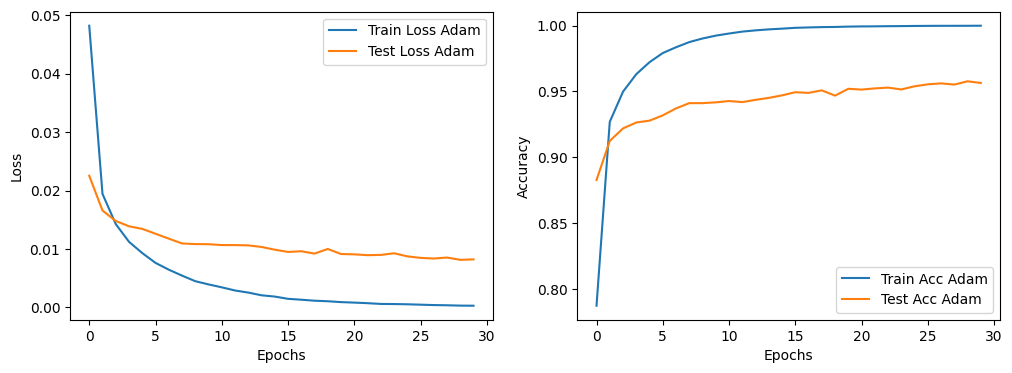

Training with AdamWithWarmup optimizer...
(60000, 28, 28)
(60000, 784)
(60000, 784) (60000, 10)
Epoch 5/30:
  Train Loss: 0.0110 | Train Acc: 0.9655
  Test Loss: 0.0132 | Test Acc: 0.9305
Epoch 10/30:
  Train Loss: 0.0047 | Train Acc: 0.9914
  Test Loss: 0.0107 | Test Acc: 0.9434
Epoch 15/30:
  Train Loss: 0.0024 | Train Acc: 0.9971
  Test Loss: 0.0099 | Test Acc: 0.9475
Epoch 20/30:
  Train Loss: 0.0014 | Train Acc: 0.9993
  Test Loss: 0.0094 | Test Acc: 0.9511
Epoch 25/30:
  Train Loss: 0.0008 | Train Acc: 0.9998
  Test Loss: 0.0087 | Test Acc: 0.9548
Epoch 30/30:
  Train Loss: 0.0004 | Train Acc: 0.9999
  Test Loss: 0.0087 | Test Acc: 0.9548


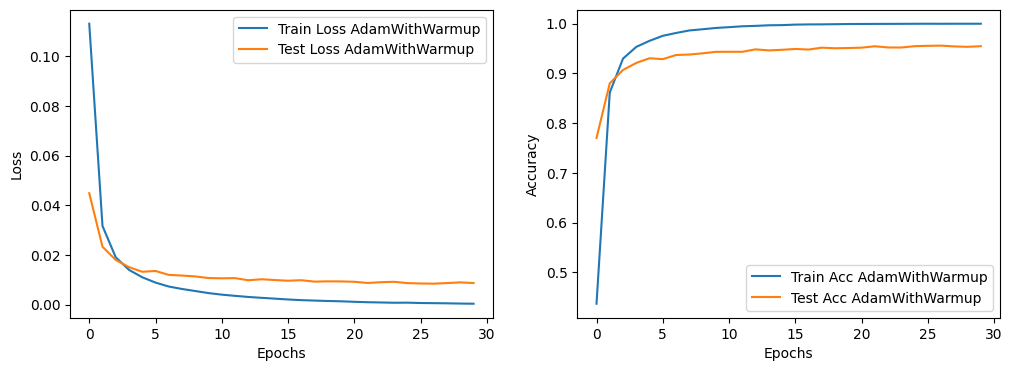

In [ ]:
optimizers = ["GD", "Momentum", "Adadelta", "Adam", "AdamWithWarmup"]
results = {}

for optimizer in optimizers:
  print(f"Training with {optimizer} optimizer...")
  model, history = train_mnist_with_optimizer(optimizer)
  results[optimizer] = history

  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(history["train_loss"], label=f"Train Loss {optimizer}")
  axs[0].plot(history["test_loss"], label=f"Test Loss {optimizer}")
  axs[0].set_xlabel("Epochs")
  axs[0].set_ylabel("Loss")
  axs[0].legend()

  axs[1].plot(history["train_acc"], label=f"Train Acc {optimizer}")
  axs[1].plot(history["test_acc"], label=f"Test Acc {optimizer}")
  axs[1].set_xlabel("Epochs")
  axs[1].set_ylabel("Accuracy")
  axs[1].legend()
  plt.show()

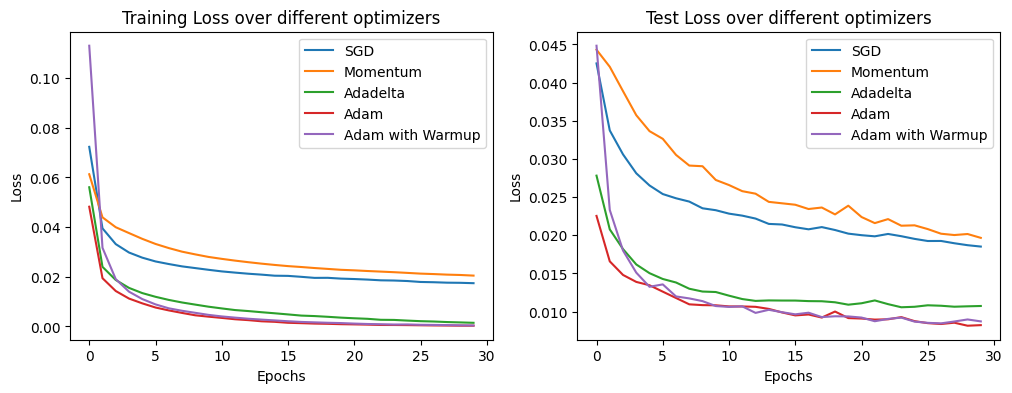

In [ ]:
history_gd_train_loss = results["GD"]["train_loss"]
history_mo_train_loss = results["Momentum"]["train_loss"]
history_add_train_loss = results["Adadelta"]["train_loss"]
history_ada_train_loss = results["Adam"]["train_loss"]
history_adawu_train_loss = results["AdamWithWarmup"]["train_loss"]

history_gd_test_loss = results["GD"]["test_loss"]
history_mo_test_loss = results["Momentum"]["test_loss"]
history_add_test_loss = results["Adadelta"]["test_loss"]
history_ada_test_loss = results["Adam"]["test_loss"]
history_adawu_test_loss = results["AdamWithWarmup"]["test_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history_gd_train_loss, label='SGD')
axs[0].plot(history_mo_train_loss, label='Momentum')
axs[0].plot(history_add_train_loss, label='Adadelta')
axs[0].plot(history_ada_train_loss, label='Adam')
axs[0].plot(history_adawu_train_loss, label='Adam with Warmup')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over different optimizers')
axs[0].legend()

axs[1].plot(history_gd_test_loss, label='SGD')
axs[1].plot(history_mo_test_loss, label='Momentum')
axs[1].plot(history_add_test_loss, label='Adadelta')
axs[1].plot(history_ada_test_loss, label='Adam')
axs[1].plot(history_adawu_test_loss, label='Adam with Warmup')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Test Loss over different optimizers')
axs[1].legend()
plt.show()

# 2. Data Visualization

You should look at https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b, which contains a very nice introduction into visualizing datasets using PCA
and tSNE.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
x_train = x_train / 255.0

To create a permutation of the inputs, we can just permute the indexes.

In [ ]:
indexes = x_train.shape[0]
indexes = np.random.permutation(indexes)
indexes

array([ 5067, 59695, 40485, ..., 35934, 12538, 55727])

In [ ]:
x_train = x_train[indexes]
y_train = y_train[indexes]

<Figure size 640x480 with 0 Axes>

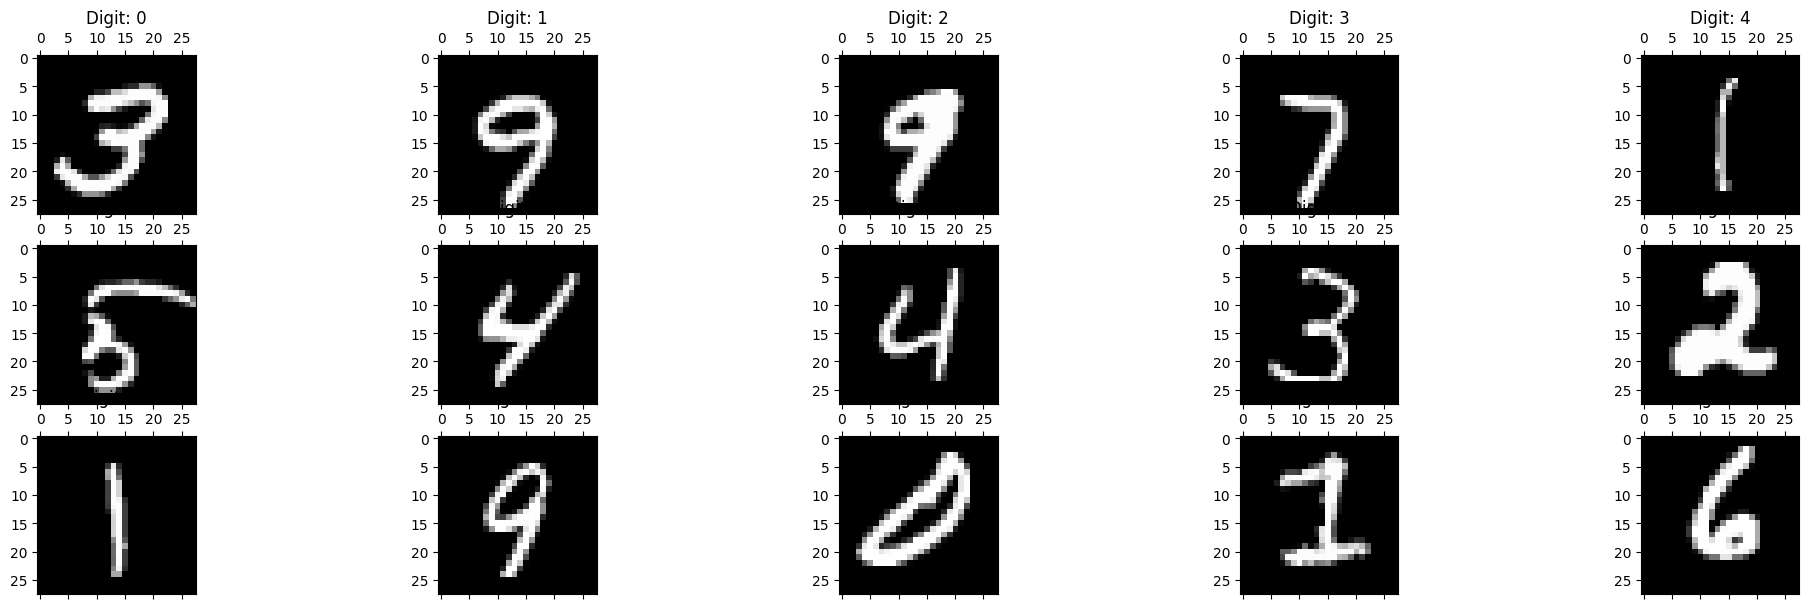

In [ ]:
plt.gray()
fig = plt.figure( figsize=(25,7) )
for i in range(0,15):
    x = x_train[i]
    y = y_train[i]
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(i)))
    ax.matshow(x)
plt.show()


In [ ]:
# we will just use the first 10000 samples
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
y_train_flatten = y_train.reshape(y_train.shape[0])
#x_train_flatten = x_train_flatten[0:1000]
#y_train_flatten = y_train_flatten[0:1000]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_flatten)

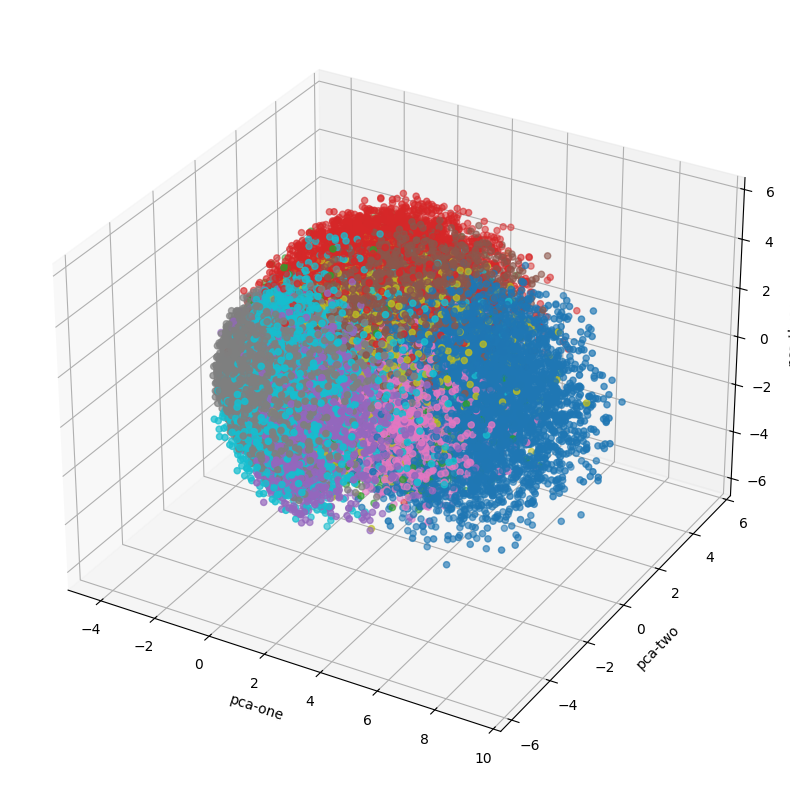

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c=y_train_flatten,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
# tSNE is very expensive to compute. Let's use only 3000 samples
x_train_flatten = x_train_flatten[0:3000]
y_train_flatten = y_train_flatten[0:3000]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_flatten)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.003s...
[t-SNE] Computed neighbors for 3000 samples in 1.201s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.480410
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.653809
[t-SNE] KL divergence after 300 iterations: 2.005424
t-SNE done! Time elapsed: 15.638115406036377 seconds


In [ ]:
data = {"x{}".format(i): x_train_flatten[:, i] for i in range(x_train_flatten.shape[1])}
data["y"] = y_train_flatten
df = pd.DataFrame(data)

In [ ]:
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


<Axes: >

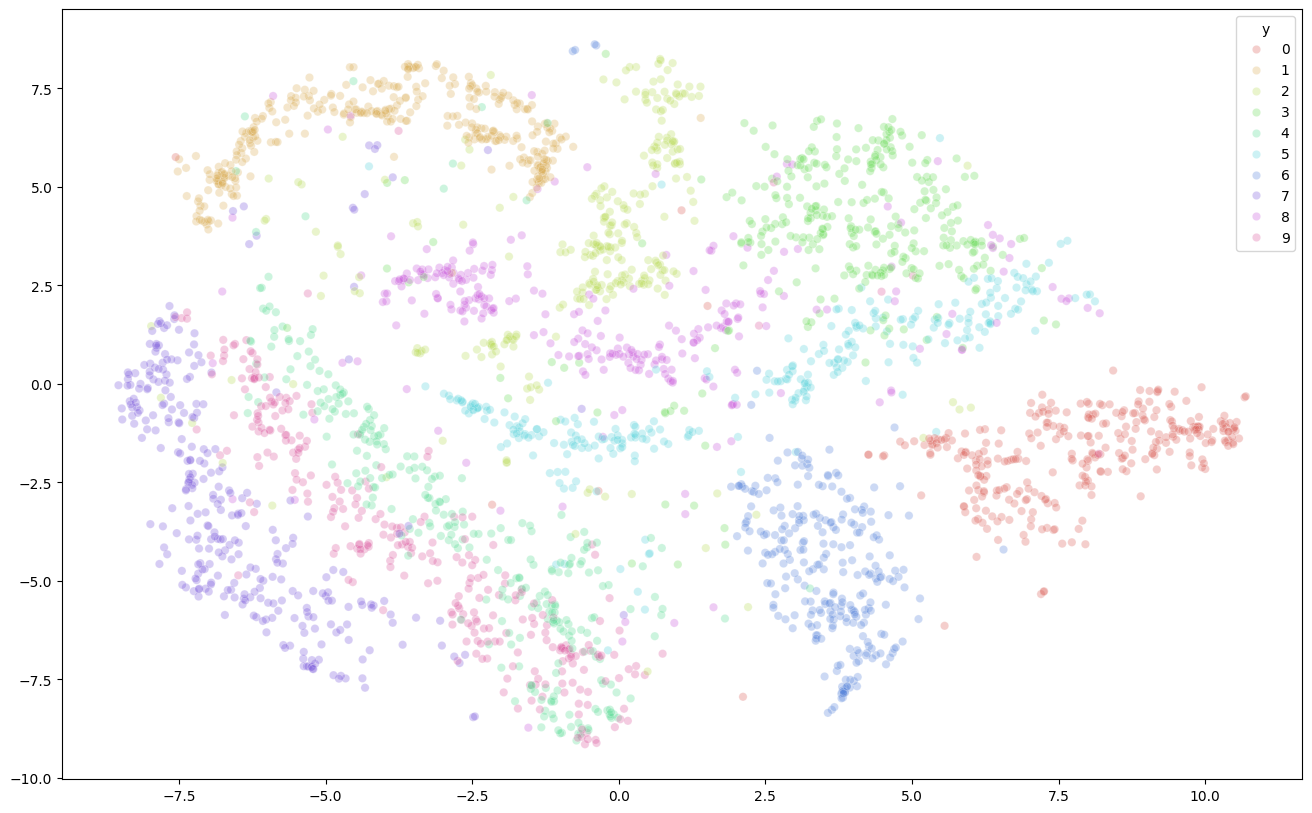

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train_flatten)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8295297042678733


In [ ]:
x_train_flatten.shape, y_train_flatten.shape, pca_result_50.shape

((3000, 784), (3000,), (3000, 50))

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 2.268438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.083298
[t-SNE] KL divergence after 300 iterations: 1.953320


<Axes: >

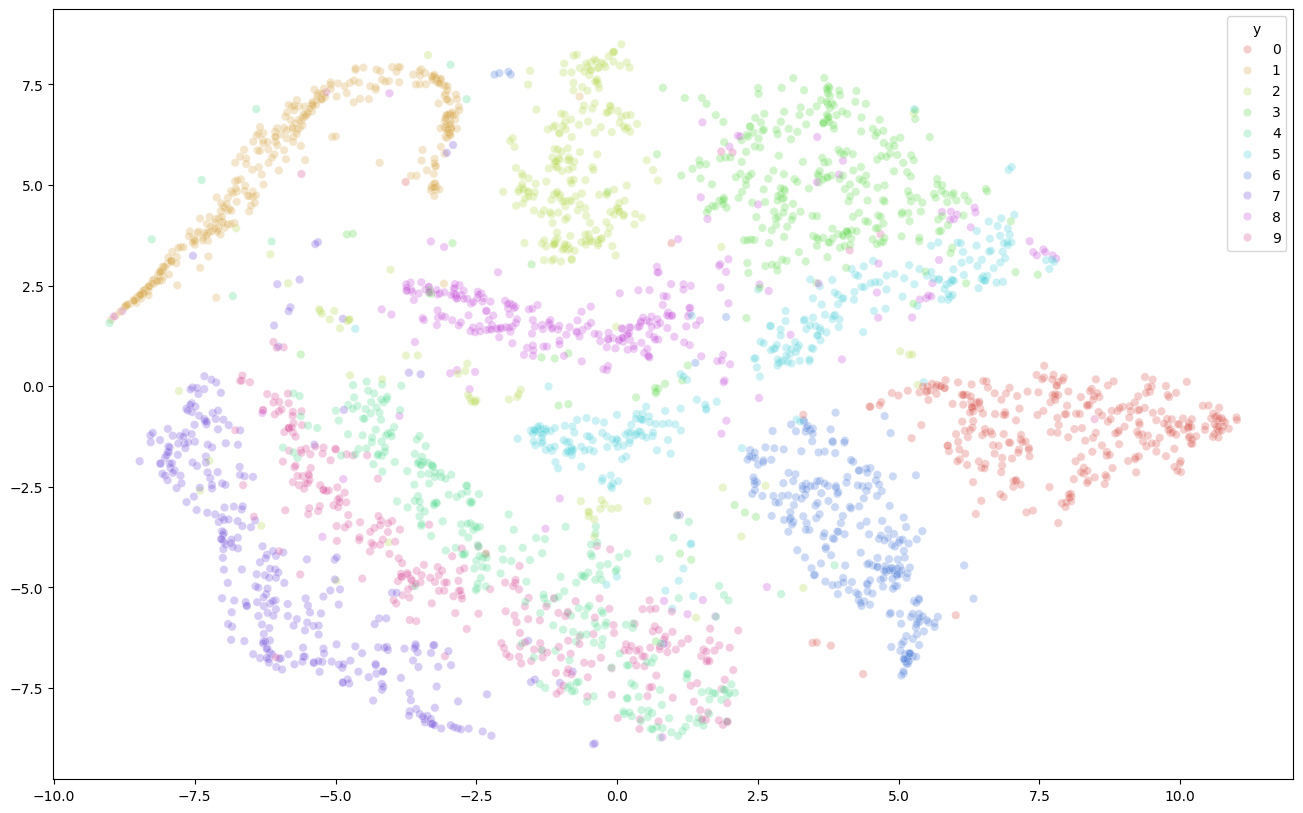

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

Now, you will perform the same exercise on cifar10 or cifar100.

In [ ]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train.shape, y_train.shape

x_train = x_train / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<Figure size 640x480 with 0 Axes>

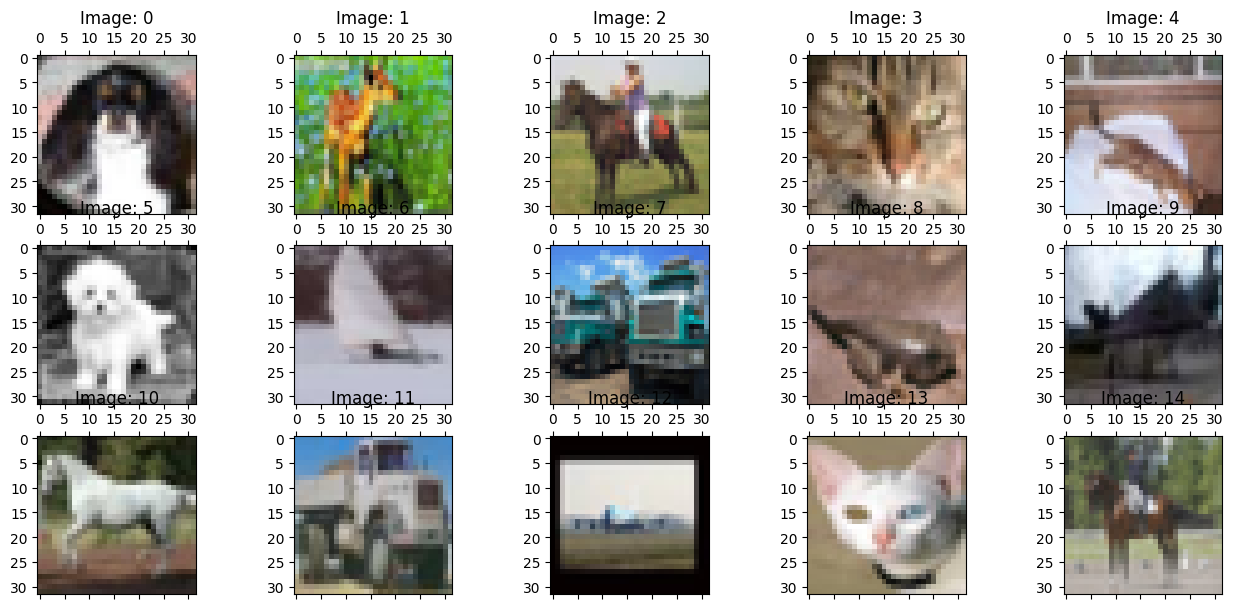

In [ ]:


indexes = x_train.shape[0]
indexes = np.random.permutation(indexes)
indexes

x_train = x_train[indexes]
y_train = y_train[indexes]

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    x = x_train[i]
    y = y_train[i]
    ax = fig.add_subplot(3,5,i+1, title="Image: {}".format(str(i)))
    ax.matshow(x)
plt.show()

In [ ]:
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
y_train_flatten = y_train.reshape(y_train.shape[0])

pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_flatten)

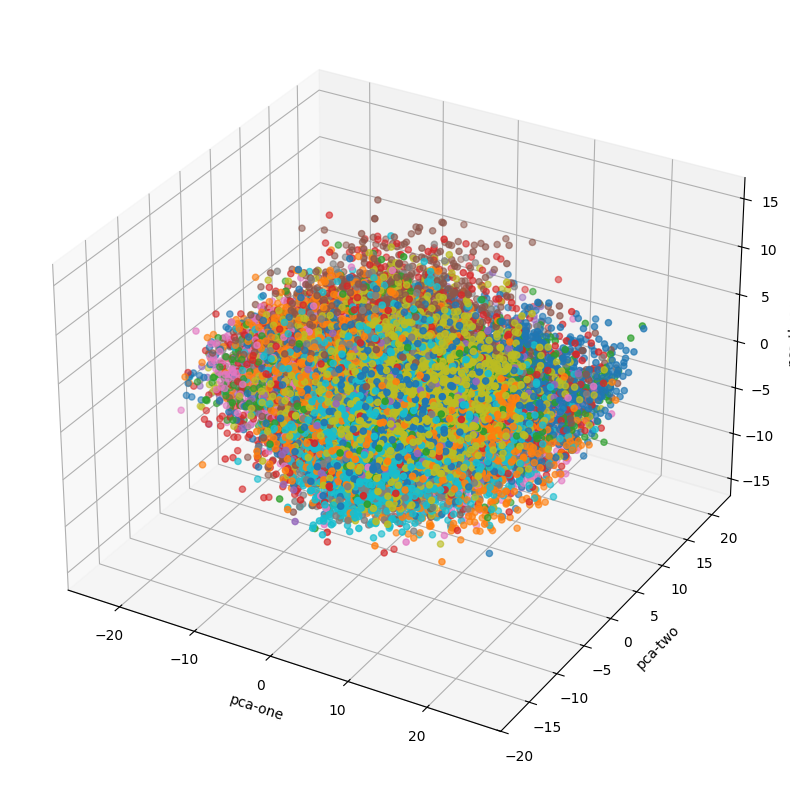

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    xs=pca_result[:,0],
    ys=pca_result[:,1],
    zs=pca_result[:,2],
    c=y_train_flatten,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
x_train_flatten = x_train_flatten[0:3000]
y_train_flatten = y_train_flatten[0:3000]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_flatten)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.011s...
[t-SNE] Computed neighbors for 3000 samples in 3.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.469163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.504700
[t-SNE] KL divergence after 300 iterations: 2.464550
t-SNE done! Time elapsed: 16.65561270713806 seconds


In [ ]:
data = {"x{}".format(i): x_train_flatten[:, i] for i in range(x_train_flatten.shape[1])}
data["y"] = y_train_flatten
df = pd.DataFrame(data)

In [ ]:
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x3063,x3064,x3065,x3066,x3067,x3068,x3069,x3070,x3071,y
0,0.227451,0.231373,0.219608,0.380392,0.372549,0.372549,0.517647,0.490196,0.505882,0.643137,...,0.286275,0.270588,0.254902,0.450980,0.435294,0.403922,0.568627,0.552941,0.517647,5
1,0.521569,0.713725,0.301961,0.466667,0.674510,0.282353,0.478431,0.733333,0.435294,0.607843,...,0.321569,0.407843,0.239216,0.333333,0.415686,0.231373,0.380392,0.454902,0.258824,4
2,0.858824,0.870588,0.905882,0.847059,0.858824,0.894118,0.847059,0.858824,0.894118,0.847059,...,0.513725,0.501961,0.270588,0.529412,0.498039,0.270588,0.490196,0.509804,0.262745,7
3,0.156863,0.152941,0.082353,0.192157,0.172549,0.105882,0.200000,0.168627,0.105882,0.200000,...,0.654902,0.592157,0.490196,0.721569,0.650980,0.549020,0.800000,0.709804,0.615686,3
4,0.431373,0.407843,0.349020,0.435294,0.411765,0.356863,0.462745,0.435294,0.400000,0.572549,...,0.239216,0.164706,0.125490,0.247059,0.160784,0.129412,0.247059,0.176471,0.137255,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.352941,0.360784,0.376471,0.537255,0.549020,0.552941,0.713725,0.725490,0.733333,0.725490,...,0.286275,0.247059,0.219608,0.258824,0.219608,0.188235,0.176471,0.141176,0.121569,2
2996,0.862745,0.960784,0.917647,0.898039,0.956863,0.929412,0.909804,0.956863,0.929412,0.909804,...,0.839216,0.862745,0.721569,0.819608,0.847059,0.701961,0.843137,0.866667,0.713725,7
2997,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,1.000000,1.000000,1.000000,1
2998,0.996078,1.000000,0.988235,0.984314,0.984314,0.972549,0.984314,0.980392,0.960784,0.988235,...,1.000000,1.000000,1.000000,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,6


<Axes: >

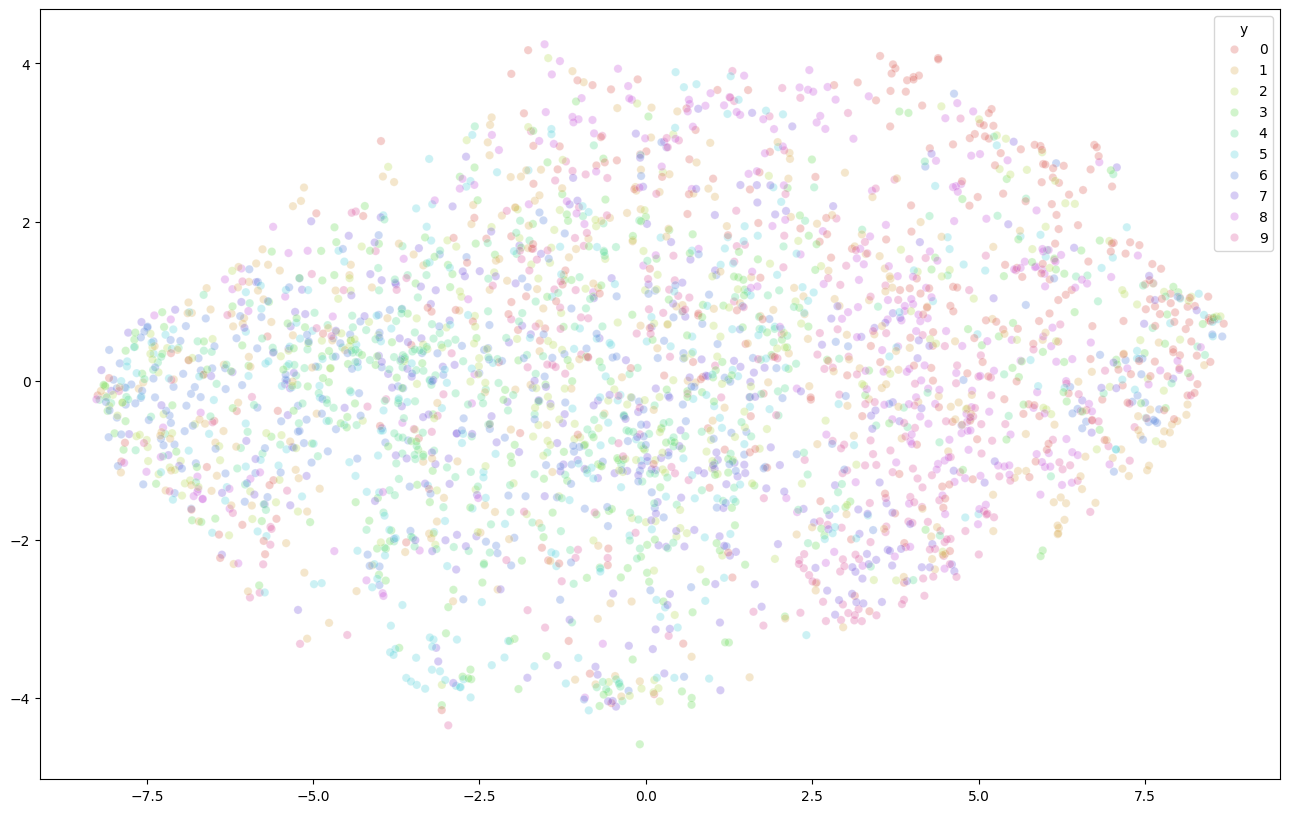

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train_flatten)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8477717721625982


In [ ]:
x_train_flatten.shape, y_train_flatten.shape, pca_result_50.shape

((3000, 3072), (3000,), (3000, 50))

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 3000 samples in 0.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 3.224581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.115746
[t-SNE] KL divergence after 300 iterations: 2.547925


<Axes: >

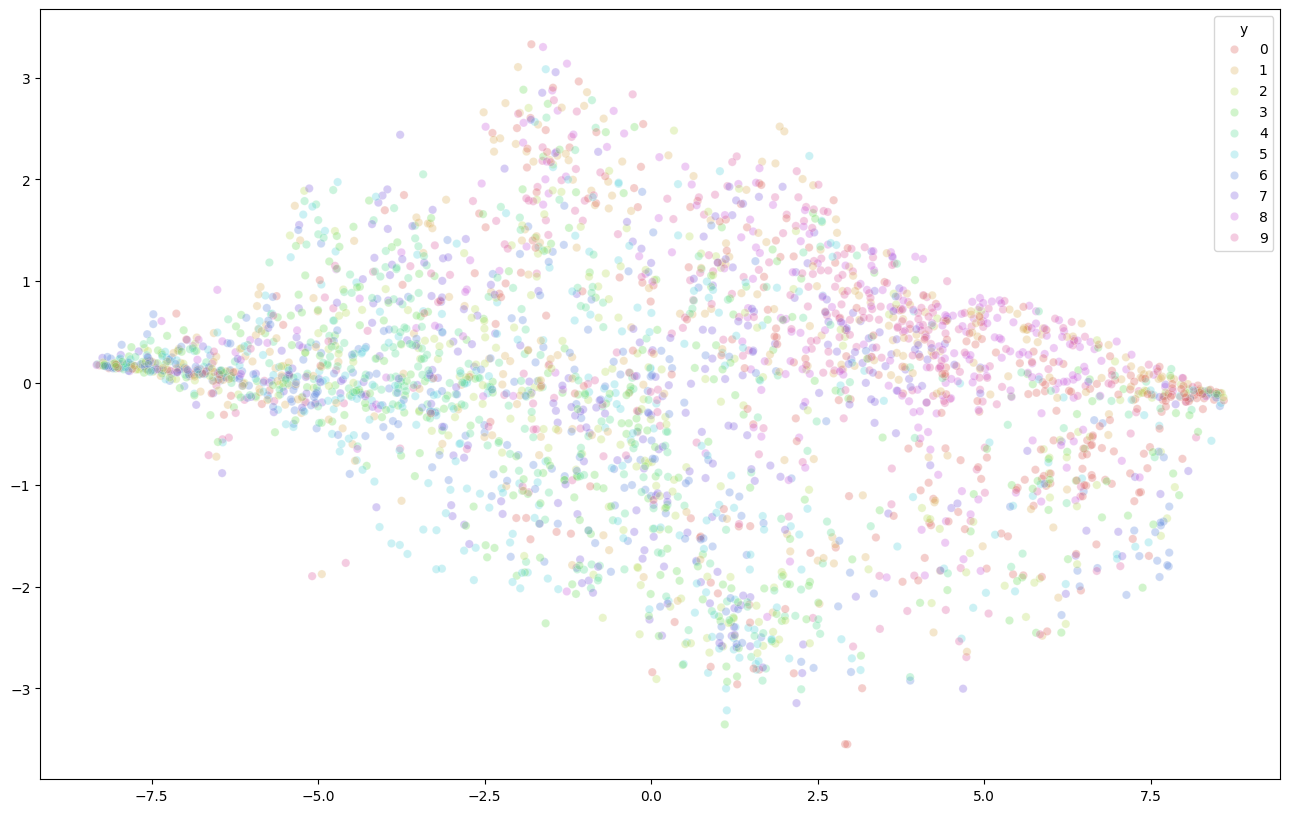

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

With the help of ChatGPT, explain the difference among PCA (SVD if you remove mean(x) and compute np.dot(X.T, X) to create a square matrix), tSNE and UMAP, explaining how it works.  I will be checking if you left ChatGPT generating the sentences and it ended up writing garbage.

PCA, tSNE, and UMAP are all dimensionality reduction techniques that aim to reduce the total dimensions of a dataset. However, each technique differs in their approaches toward reducing dimensionality and their assumptions about the dataset itself.

For PCA, short for Principal Component Analysis, it reduces the dimensionality of the dataset by projecting the dataset onto a new set of orthogonal axes, called its principal components. The components selected to represent each axes are chosen by whichever components have the highest variance, and therefore are able to capture the most information about each datapoint in the dataset. PCA also assumes that the relationships between datapoints in the dataset are linear.

For tSNE, short for t-Distributed Stochastic Neighbor Embedding, instead of relying on mathematical relationships between datapoints, it calculates the similarities between pairs of datapoints using a probabilisitc distribution. Basically, the closer two points are to each other, the more likely that the two points are "neighbors", and therefore belong in the same cluster. It then reduces the dimensionality of the dataset while trying to preserve the probabilites between datapoint. Using this technique, tSNE is able to capture nonlinear relationships within the dataset. However, this comes at the cost at being much more computationally expensive than PCA.

Finally, for UMAP, it works off the same principles as tSNE, where it tries find connections between datapoints using a probablisitic distribuiton, with the strength of each connection dependent on the distance between the two datapoints. However, unlike tSNE, it models all of these connections at once in a graph, looking at the big picture of all the connections instead of focusing down on each individual connection. UMAP reduces dimensionality while trying to preserve the topological structure of the graph, instead of the individual probabilites like in tSNE. This leads to a projection that is still able to model nonlinear relationships within the data, while being less computationally expensive than tSNE.